In [1]:
from utils import *
import matplotlib.pyplot as plt

In [3]:
source, dest, lons, lats, dtime = mapbox_parser('Holländische Reihe 15, Hamburg',
             'Bundesstrasse 53, Hamburg', 'walking')

In [7]:
df = pd.DataFrame({'lons': lons, 
               'lats': lats, 
               'dtime': dtime.seconds.values,
               'source':source,
              'destination': dest})

In [68]:
def strfdelta(tdelta, fmt):
    d = {"days": tdelta.days}
    d["hours"], rem = divmod(tdelta.seconds, 3600)
    d["minutes"], d["seconds"] = divmod(rem, 60)
    return fmt.format(**d)

In [75]:
[strfdelta(delta, fmt="{hours}h {minutes}m") for delta in pd.to_timedelta(df.dtime, unit='s')]

['0h 0m',
 '0h 0m',
 '0h 1m',
 '0h 1m',
 '0h 1m',
 '0h 2m',
 '0h 2m',
 '0h 2m',
 '0h 3m',
 '0h 3m',
 '0h 3m',
 '0h 4m',
 '0h 4m',
 '0h 5m',
 '0h 5m',
 '0h 5m',
 '0h 5m',
 '0h 6m',
 '0h 6m',
 '0h 6m',
 '0h 6m',
 '0h 6m',
 '0h 6m',
 '0h 6m',
 '0h 6m',
 '0h 7m',
 '0h 7m',
 '0h 7m',
 '0h 7m',
 '0h 7m',
 '0h 8m',
 '0h 8m',
 '0h 8m',
 '0h 8m',
 '0h 9m',
 '0h 9m',
 '0h 9m',
 '0h 9m',
 '0h 10m',
 '0h 10m',
 '0h 10m',
 '0h 10m',
 '0h 10m',
 '0h 10m',
 '0h 10m',
 '0h 10m',
 '0h 11m',
 '0h 11m',
 '0h 11m',
 '0h 12m',
 '0h 12m',
 '0h 12m',
 '0h 14m',
 '0h 15m',
 '0h 15m',
 '0h 15m',
 '0h 15m',
 '0h 15m',
 '0h 16m',
 '0h 17m',
 '0h 17m',
 '0h 18m',
 '0h 18m',
 '0h 19m',
 '0h 19m',
 '0h 19m',
 '0h 19m',
 '0h 19m',
 '0h 20m',
 '0h 20m',
 '0h 20m',
 '0h 20m',
 '0h 21m',
 '0h 21m',
 '0h 21m',
 '0h 21m',
 '0h 22m',
 '0h 22m',
 '0h 22m',
 '0h 22m',
 '0h 22m',
 '0h 22m',
 '0h 23m',
 '0h 23m',
 '0h 23m',
 '0h 23m',
 '0h 24m',
 '0h 24m',
 '0h 24m',
 '0h 24m',
 '0h 24m',
 '0h 24m',
 '0h 25m',
 '0h 25m',
 '0h

In [84]:
def generate_map_plot(df):
    if df is not None:
        lons = df.lons.values
        lats = df.lats.values
        start_point = df.source.values[0]
        end_point = df.destination.values[0]
        zoom, center = zoom_center(lons, lats,
                                   width_to_height=8)

        fig = go.Figure(go.Scattermapbox(
            lat=lats,
            lon=lons,
            mode='lines',
            line=dict(width=2),
            marker=dict(
                size=5,
            ),
        name='itinerary',
        hovertext=[strfdelta(delta, fmt="{hours}h {minutes}m") 
                   for delta in pd.to_timedelta(df.dtime, unit='s')]))
        
        fig.add_trace(go.Scattermapbox(
            lat=[lats[0]],
            lon=[lons[0]],
            mode='markers',
            marker=dict(
                size=15,
            ),name='Start',
         hovertext=start_point))

        fig.add_trace(go.Scattermapbox(
            lat=[lats[-1]],
            lon=[lons[-1]],
            mode='markers',
            marker=dict(
                size=15,
            ),name='Destination',
         hovertext=end_point))

        fig.update_layout(
            showlegend=False,
            hovermode='closest',
            mapbox=dict(
                accesstoken=apiKey,
                center=go.layout.mapbox.Center(
                    lat=center['lat'],
                    lon=center['lon']
                ),
                zoom=zoom
            )
        )
    else:# make an empty map
        fig = go.Figure(go.Scattermapbox())

        fig.update_layout(
            mapbox=dict(
                accesstoken=apiKey,
                center=go.layout.mapbox.Center(
                    lat=51.326863,
                    lon=10.354922
                ),
                zoom=4
            )
        )
        
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0},
        height=300)
    return fig

In [85]:
fig = generate_map_plot(df)
fig.show()

In [26]:
proj_defs = {
    'euratl':
    {
        'extents':[-23.5, 45, 29.5, 70.5],
        'resolution': '50m',
        'regions':False
    },
    'it':
    {
        'extents':[6, 19, 36, 48],
        'resolution': '10m',
        'regions':True
    },
    'de':
    {
        'extents':[5, 16, 46.5, 56],
        'resolution': '10m',
        'regions':True
    }
}

In [27]:
def get_projection_cartopy(plt, projection="euratl", compute_projection=False):
    '''Retrieve the projection using cartopy'''
    if compute_projection:
        import cartopy.crs as ccrs
        import cartopy.feature as cfeature
        import cartopy.io.shapereader as shpreader

        proj_opts = proj_defs[projection]

        ax = plt.axes(projection=ccrs.PlateCarree())

        ax.set_extent(proj_opts['extents'], ccrs.PlateCarree())
        ax.coastlines(resolution=proj_opts['resolution'])
        ax.add_feature(cfeature.BORDERS.with_scale(proj_opts['resolution']))

        if proj_opts['regions']:
            states_provinces = cfeature.NaturalEarthFeature(
                category='cultural',
                name='admin_1_states_provinces_lines',
                scale=proj_opts['resolution'],
                facecolor='none')
            ax.add_feature(states_provinces, edgecolor='black', alpha=.5)

        return(ax)
    else:
        return(add_background(plt, projection, image=projection+"_background.png"))

In [14]:
lon_radar, lat_radar, time_radar, dtime_radar, rr = get_radar_data()

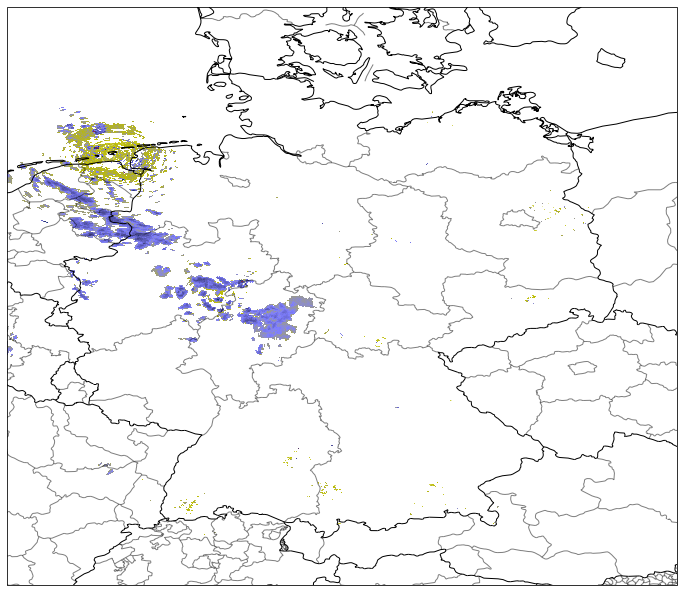

In [33]:
fig = plt.figure(figsize=(12, 12))

ax = get_projection_cartopy(plt, projection='de', compute_projection=True)

ax.pcolormesh(lon_radar, lat_radar, rr[0], cmap='gist_stern_r')